<a href="https://colab.research.google.com/github/ansonmiu0214/SessionTS-Benchmarks/blob/master/SessionTS_Benchmarks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SessionTS Benchmarks

To analyse performance bottleneck in session runtimes 
for Node and React endpoints.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

%matplotlib inline

In [2]:
import os
import shutil

BENCHMARK_PATH = '/content/SessionTS-Benchmarks'
if os.path.exists(BENCHMARK_PATH):
    print('Note: deleting stale repo')
    shutil.rmtree(BENCHMARK_PATH)

!git clone https://github.com/ansonmiu0214/SessionTS-Benchmarks.git
assert os.path.exists(BENCHMARK_PATH)

Note: deleting stale repo
Cloning into 'SessionTS-Benchmarks'...
remote: Enumerating objects: 490, done.
remote: Counting objects: 100% (490/490), done.
remote: Compressing objects: 100% (387/387), done.
remote: Total 490 (delta 111), reused 463 (delta 99), pack-reused 0
Receiving objects: 100% (490/490), 6.77 MiB | 17.17 MiB/s, done.
Resolving deltas: 100% (111/111), done.


## Helper Functions

In [3]:
import typing

def average(xs):
    """Compute average of a list."""

    return float(sum(xs)) / float(len(xs))

def from_ms(ms):
    """Parse numerical millisecond value from string suffixed with 'ms."""

    if not ms.endswith('ms'):
        raise Exception(f'Cannot parse millisecond value from: {ms}')
    return float(ms[:-2])

def parse_pingpong(line):
    _, time = line.split(' ')
    return from_ms(time)

def parse_console_timestamp(line):
    _, time, _ = line.split(' ')
    return from_ms(time)

def parse_total(line):
    _, time = line.split(' ')
    return from_ms(time)

## Data Loader

In [4]:
from collections import namedtuple

Log = namedtuple('Log',
                 ('benchmark_times', 'benchmark_total', 'message_times'))

class BenchmarkInstance:

    def __init__(self, *, 
                 variant,
                 num_msgs,
                 node_logs: typing.List[Log],
                 react_logs: typing.List[Log]):
        self.variant = variant
        self.num_msgs = num_msgs
        self._node_logs = node_logs
        self._react_logs = react_logs

    def _extract_log_attr(self, log_name, log_attr):
        return [getattr(log, log_attr)
                for log in getattr(self, f'_{log_name}_logs')]

    def _aggregate_average(self, log_name, log_attr):
        transposed = list(zip(*self._extract_log_attr(log_name, log_attr)))
        return [average(items) for items in transposed]

    def avg_timeline(self, endpoint):
        return self._aggregate_average(endpoint, 'message_times')

    def avg_benchmark_total(self, endpoint):
        return average(self._extract_logs(endpoint, 'benchmark_total'))

    def avg_benchmark(self, endpoint):
        return self._aggregate_average(endpoint, 'benchmark_times')

class BenchmarkLibrary:

    def __init__(self, instances):
        self._instances = instances

    def get(self, *, variant, num_msgs):
        result = [instance for instance in self._instances
                  if instance.variant == variant and instance.num_msgs == num_msgs]
        if not result:
            raise Exception(f'Cannot find log: {variant}, {num_msgs}')
        return result[0]

    def get_multiple(self, *, variant=None, num_msgs=None):
        if variant is not None:
            return [instance for instance in self._instances
                    if instance.variant == variant]
        if num_msgs is not None:
            return [instance for instance in self._instances
                    if instance.num_msgs == num_msgs]
        return []

In [5]:
def parse_node_log(log):
    lines = [line.strip() for line in log.split('\n') if line.strip()]

    # Get benchmark timestamps
    benchmark_times = [line for line in lines if line.startswith('benchmark:')]
    benchmark_timestamps = [parse_console_timestamp(line)
                            for line in benchmark_times[:-1]]
    benchmark_total = parse_total(benchmark_times[-1])

    # Get pingpong timestamps
    pingpong_timestamps = [parse_pingpong(line)
                           for line in lines if line.startswith('pingpong')]

    return benchmark_times, benchmark_total, pingpong_timestamps

def parse_react_log(log):
    lines = [' '.join(line.strip().split(' ')[1:])
             for line in log.split('\n') if line.strip()]

    # Get benchmark timestamps
    benchmark_times = [line for line in lines if line.startswith('benchmark:')]
    benchmark_timestamps = [parse_console_timestamp(line)
                            for line in benchmark_times[:-1]]
    benchmark_total = parse_total(benchmark_times[-1])

    # Get pingpong timestamps
    pingpong_timestamps = [parse_pingpong(line)
                           for line in lines if line.startswith('pongping')]

    return benchmark_times, benchmark_total, pingpong_timestamps[:len(benchmark_timestamps)]

In [6]:
def accumulate_logs(*, variant, num_msgs):

    node_path = os.path.join(BENCHMARK_PATH, variant, 'server', 'finelogs')
    node_log_filenames = [os.path.join(node_path, path) 
                          for path in os.listdir(node_path)
                          if int(path.split('_')[0]) == num_msgs]

    react_path = os.path.join(BENCHMARK_PATH, variant, 'client', 'finelogs')
    react_log_filenames = [os.path.join(react_path, path) 
                          for path in os.listdir(react_path)
                          if int(path.split('_')[0]) == num_msgs]

    node_logs = []
    react_logs = []

    for node_log, react_log in zip(node_log_filenames, react_log_filenames):
        with open(node_log, 'r') as node_file:
            node_logs.append(Log(*parse_node_log(node_file.read())))

        with open(react_log, 'r') as react_file:
            react_logs.append(Log(*parse_react_log(react_file.read())))

    return BenchmarkInstance(variant=variant,
                             num_msgs=num_msgs,
                             node_logs=node_logs,
                             react_logs=react_logs)

In [7]:
VARIANTS = ('bare', 'mpst')
NUM_MSGS = (100, 1000)
ENDPOINTS = ('node', 'react')

instances = [accumulate_logs(variant=variant, num_msgs=num_msgs)
             for variant in VARIANTS
             for num_msgs in NUM_MSGS]

library = BenchmarkLibrary(instances)

## Compare message processing times between Node and React

Time taken for each round trip is dominated by the message processing logic 
in React.

In [8]:
def plot_react_node_breakdown(library, fig, axs, *, 
                              variant,
                              num_msgs):
    log_instance = library.get(variant=variant, num_msgs=num_msgs)
    node = log_instance.avg_timeline('node')
    react = log_instance.avg_timeline('react')
    
    time_axis = np.arange(num_msgs)
    axs.stackplot(time_axis, [react, node], labels=['React', 'Node'])
    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    axs.set_title(f'{variant}: {num_msgs} round trips')
    axs.legend(loc='best')

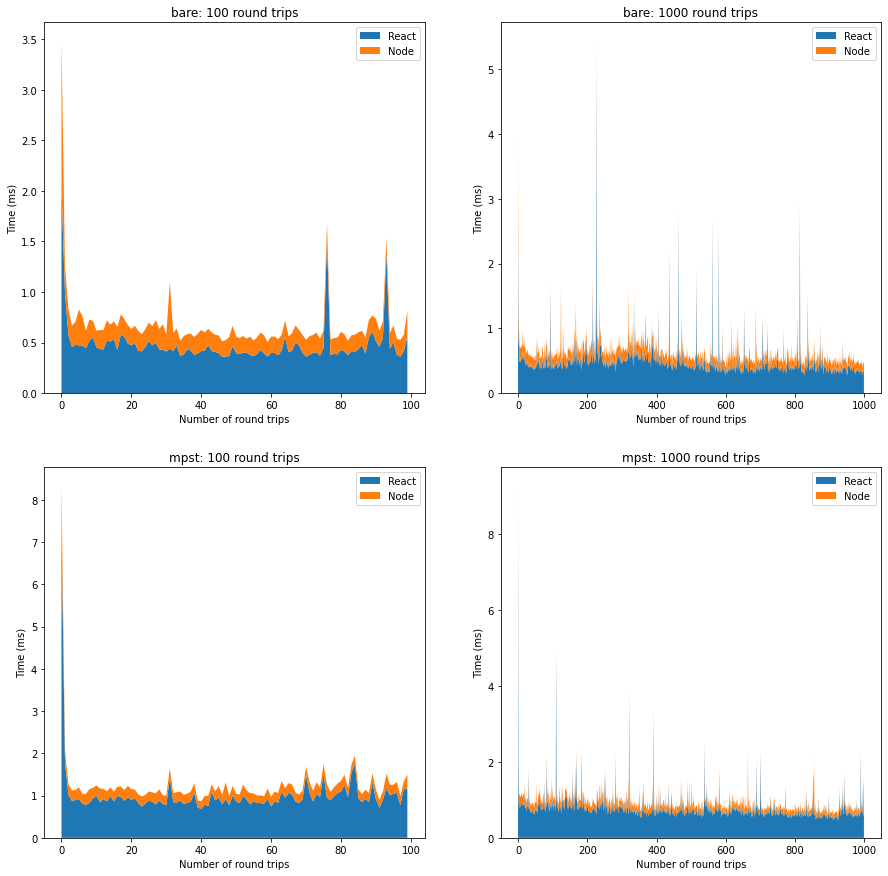

In [9]:
fig = plt.figure(figsize=(15, 15))

for i, variant in enumerate(VARIANTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(VARIANTS), len(NUM_MSGS), idx)
        plot_react_node_breakdown(library, fig, axs,
                                  variant=variant, num_msgs=num_msgs)

## Compare overhead of MPST implementation for each endpoint

Session runtime in React incurs most of the overhead.

In [10]:
def compare_endpoint_log(library, fig, axs, *,
                         endpoint,
                         num_msgs):
    bare = library.get(variant='bare', num_msgs=num_msgs)
    mpst = library.get(variant='mpst', num_msgs=num_msgs)

    bare_times = bare.avg_timeline(endpoint)
    mpst_times = mpst.avg_timeline(endpoint)

    time_axis = np.arange(num_msgs)

    axs.plot(time_axis, bare_times, label=f'bare {endpoint}')
    axs.plot(time_axis, mpst_times, label=f'mpst {endpoint}')

    axs.set_xlabel('Number of round trips')
    axs.set_ylabel('Time (ms)')
    axs.set_title(f'Message processing times for {endpoint} '
                  f'through {num_msgs} round trips')
    axs.legend(loc='best')

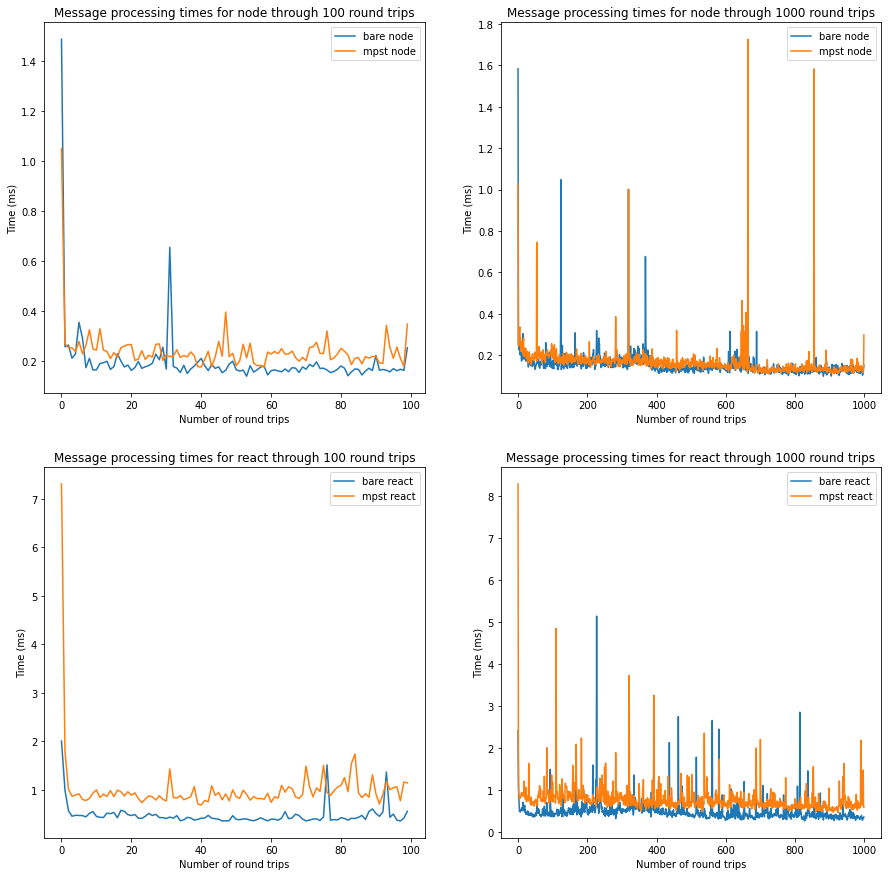

In [11]:
fig = plt.figure(figsize=(15, 15))

for i, endpoint in enumerate(ENDPOINTS):
    for j, num_msgs in enumerate(NUM_MSGS):
        idx = i * len(ENDPOINTS) + j + 1
        axs = fig.add_subplot(len(ENDPOINTS), len(NUM_MSGS), idx)
        compare_endpoint_log(library, fig, axs,
                             endpoint=endpoint,
                             num_msgs=num_msgs)

In [12]:
def compare_average_elapsed(library, *, endpoint, fmt='.7f'):
    df = pd.DataFrame(columns=(*VARIANTS, 'delta'),
                      index=NUM_MSGS)
    
    for msg_count in NUM_MSGS:
        bare = library.get(variant='bare', num_msgs=msg_count)
        mpst = library.get(variant='mpst', num_msgs=msg_count)

        bare_avg = average(bare.avg_timeline(endpoint))
        mpst_avg = average(mpst.avg_timeline(endpoint))
        avgs = [format(value, fmt)
                for value in (bare_avg, mpst_avg)]
        delta = (mpst_avg - bare_avg) / bare_avg * 100
        
        df.loc[msg_count] = [*avgs, '{:.2f}%'.format(delta)]

    return df

print('Average message processing time for Node')
display(compare_average_elapsed(library, endpoint='node'))
print()

print('Average message processing time for React')
display(compare_average_elapsed(library, endpoint='react'))
print()

Average message processing time for Node


,bare,mpst,delta
100,0.1976400,0.2400955,21.48%
1000,0.1529411,0.1660195,8.55%



Average message processing time for React


,bare,mpst,delta
100,0.4794017,1.0136086,111.43%
1000,0.4839099,0.7716999,59.47%
